### 가위바위보 분류기 만들기
루브릭 및 과정
1. 이미지 분류기 모델이 성공적으로 만들어졌는가?  
학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음  
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음  
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
60% 이상 도달

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)

2.9.1
1.21.5


데이터 로드 및 Resize  
촬영한 사진 데이터를 불러오고, 28*28로 resize할 것

In [2]:
from PIL import Image
import glob
import os

In [3]:
# 데이터셋 변환, 한번만 할 것
r_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\rock'
s_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\scissor'
p_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\paper'

os.chdir('C:\\Users\\wader\\workplace')
print(os.getcwd())

C:\Users\wader\workplace


In [4]:
def resize_images(path):
    img_list=os.listdir(path)
    target_size=(28,28)
    os.chdir(path)
    for i in img_list:
        full_path=os.path.join(path, i)
        big_img=Image.open(full_path)
        sm_img=big_img.resize(target_size, Image.ANTIALIAS)
        sm_img.save(i, "JPEG")

In [5]:
resize_images(r_path)
resize_images(s_path)
resize_images(p_path)

C:\Users\wader\AppData\Local\Temp\ipykernel_2188\2826604337.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  sm_img=big_img.resize(target_size, Image.ANTIALIAS)


이미지 파일을 적절하게 불러오기 위해, 교육 자료에서 제시한 함수를 수정하여 사용하였다. load_data()는 실행시 img_path로부터 rock, scissor, paper의 세 폴더에 들어가서 각 값들을 불러온다.(img_path에 rock, scissor, paper의 폴더가 각각 필요하다.)

In [6]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    
    sci_list=os.listdir(img_path+'scissor\\')
    rok_list=os.listdir(img_path+'rock\\')
    pap_list=os.listdir(img_path+'paper\\')
    
    
    for file in sci_list:
        file= img_path+'scissor\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in rok_list:
        file= img_path+'rock\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in pap_list:
        file= img_path+'paper\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\rock_scissor_paper\\"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

test_dir_path = "C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\test\\rock_scissor_paper\\"
(x_test, y_test)=load_data(test_dir_path)
x_test_norm = x_test/255.0

print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

데이터의 이미지 개수는 300 입니다.
데이터의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


받아온 값을 실제로 실행시켜 보았다.

2


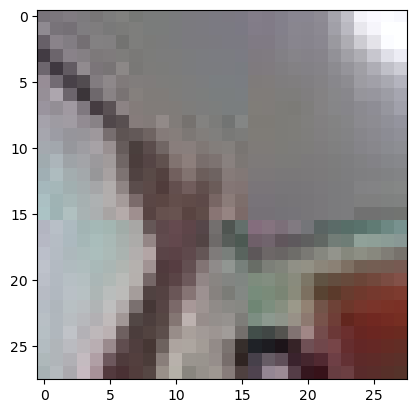

In [7]:
plt.imshow(x_train[200])
print(y_train[200])

딥러닝 네트워크 설계: 1차 시도는 학습자료에 나온대로 적용

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [9]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                2

In [11]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 1s 11ms/step - loss: 1.1029 - accuracy: 0.3167
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 1.0858 - accuracy: 0.6033
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 1.0663 - accuracy: 0.4767
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 1.0383 - accuracy: 0.5700
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.9883 - accuracy: 0.5867
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.9107 - accuracy: 0.6000
Epoch 7/10
10/10 [==============================] - 0s 16ms/step - loss: 0.8054 - accuracy: 0.6467
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.6827 - accuracy: 0.7700
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: 0.5746 - accuracy: 0.7600
Epoch 10/10
10/10 [==============================] - 0s 12ms/step - loss: 0.5292 - accuracy: 0.7933


In [12]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 2.2639 - accuracy: 0.4000 - 373ms/epoch - 37ms/step
test_loss: 2.263859748840332
test_accuracy: 0.4000000059604645


예상했던 대로 높은 수치의 값이 나오지 않았다. 반복하여 돌렸을 때, 0.3에서 0.5 정도의 값이 나왔으며, 0.5가 나왔다고 한들 큰 의미를 두기는 어려워 보인다. 데이터셋, 모델 설계, 매개변수 등 다양한 요소들에 대해 실험해 보도록 하자. 먼저, 가장 쉽게 할 수 있는 매개변수 조작부터 실행해 보았다.

In [13]:
n_channel_1=128
n_channel_2=256
n_dense=50
n_train_epoch=20


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [14]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/20
10/10 [==============================] - 2s 128ms/step - loss: 1.1003 - accuracy: 0.3833
Epoch 2/20
10/10 [==============================] - 1s 88ms/step - loss: 0.9596 - accuracy: 0.6633
Epoch 3/20
10/10 [==============================] - 1s 94ms/step - loss: 0.7334 - accuracy: 0.6833
Epoch 4/20
10/10 [==============================] - 1s 92ms/step - loss: 0.4853 - accuracy: 0.8200
Epoch 5/20
10/10 [==============================] - 1s 92ms/step - loss: 0.3719 - accuracy: 0.8333
Epoch 6/20
10/10 [==============================] - 1s 89ms/step - loss: 0.3162 - accuracy: 0.8667
Epoch 7/20
10/10 [==============================] - 1s 93ms/step - loss: 0.2379 - accuracy: 0.9167
Epoch 8/20
10/10 [==============================] - 1s 89ms/step - loss: 0.1783 - accuracy: 0.9467
Epoch 9/20
10/10 [==============================] - 1s 93ms/step - loss: 0.1270 - accuracy: 0.9833
Epoch 10/20
10/10 [==============================] - 1s 98ms/step - loss: 0.0919 - accuracy: 0.9967
Epoch 11

In [15]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 1s - loss: 3.4720 - accuracy: 0.4667 - 696ms/epoch - 70ms/step
test_loss: 3.4720101356506348
test_accuracy: 0.46666666865348816


여러번의 시행을 해봤지만 만족할만한 결과를 얻을 수는 없었다. 모델은 낮게는 0.35, 높게는 0.50 대의 정확도를 보여주었으며, 거의 달라진 것은 없었다. 그래서 통합 데이터셋을 사용하였다.
# 통합 데이터셋 사용

In [72]:
# 통합 데이터셋 변환 한번만 할 것
r_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\ent_data\\rock_scissor_paper\\rock'
s_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\ent_data\\rock_scissor_paper\\scissor'
p_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\ent_data\\rock_scissor_paper\\paper'


resize_images(r_path)
resize_images(s_path)
resize_images(p_path)

C:\Users\wader\AppData\Local\Temp\ipykernel_2188\2826604337.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  sm_img=big_img.resize(target_size, Image.ANTIALIAS)


In [73]:
import numpy as np

def load_data_ent(img_path, number_of_data=7372):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    
    sci_list=os.listdir(img_path+'scissor\\')
    rok_list=os.listdir(img_path+'rock\\')
    pap_list=os.listdir(img_path+'paper\\')
    
    
    for file in sci_list:
        file= img_path+'scissor\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in rok_list:
        file= img_path+'rock\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in pap_list:
        file= img_path+'paper\\'+file
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [74]:
ent_image_dir_path='C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\ent_data\\rock_scissor_paper\\'
(x_train, y_train)=load_data_ent(ent_image_dir_path)
x_train_norm = x_train/255.0   

test_dir_path = "C:\\Users\\wader\\workplace\\ess_data\\[E-05]Tensor_First\\test\\rock_scissor_paper\\"
(x_test, y_test)=load_data(test_dir_path)
x_test_norm = x_test/255.0

데이터의 이미지 개수는 7372 입니다.
데이터의 이미지 개수는 300 입니다.


In [75]:
print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (7372, 28, 28, 3)
y_train shape: (7372,)


0


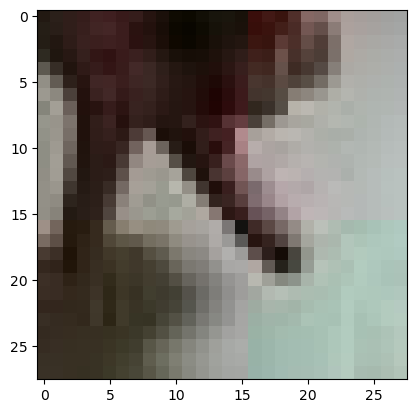

In [76]:
plt.imshow(x_train[500])
print(y_train[500])

In [77]:
# model=keras.models.Sequential()
# model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
# model.add(keras.layers.MaxPool2D(2,2))
# model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
# model.add(keras.layers.MaxPooling2D((2,2)))
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(32, activation='relu'))
# model.add(keras.layers.Dense(3, activation='softmax'))

# 노드 기본 레이어 및 파라미터로 테스트
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [78]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/10
231/231 [==============================] - 3s 8ms/step - loss: 0.9748 - accuracy: 0.5210
Epoch 2/10
231/231 [==============================] - 2s 8ms/step - loss: 0.5991 - accuracy: 0.7633
Epoch 3/10
231/231 [==============================] - 2s 7ms/step - loss: 0.4045 - accuracy: 0.8376
Epoch 4/10
231/231 [==============================] - 1s 6ms/step - loss: 0.2831 - accuracy: 0.8893
Epoch 5/10
231/231 [==============================] - 6s 27ms/step - loss: 0.2173 - accuracy: 0.9183
Epoch 6/10
231/231 [==============================] - 2s 10ms/step - loss: 0.1688 - accuracy: 0.9399
Epoch 7/10
231/231 [==============================] - 2s 9ms/step - loss: 0.1331 - accuracy: 0.9501
Epoch 8/10
231/231 [==============================] - 2s 8ms/step - loss: 0.1017 - accuracy: 0.9660
Epoch 9/10
231/231 [==============================] - 2s 7ms/step - loss: 0.0898 - accuracy: 0.9712
Epoch 10/10
231/231 [==============================] - 2s 7ms/step - loss: 0.0753 - accuracy: 0.97

In [79]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 2.3325 - accuracy: 0.6200 - 479ms/epoch - 48ms/step
test_loss: 2.3324732780456543
test_accuracy: 0.6200000047683716


In [ ]:
# https://sevillabk.github.io/1-learning-visualiztion/